[40.0]


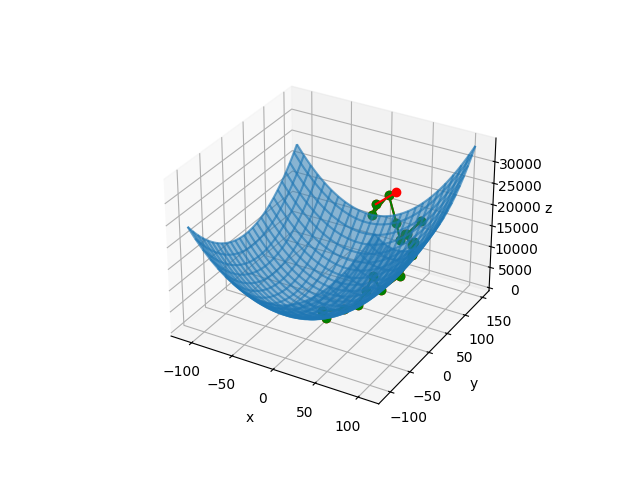

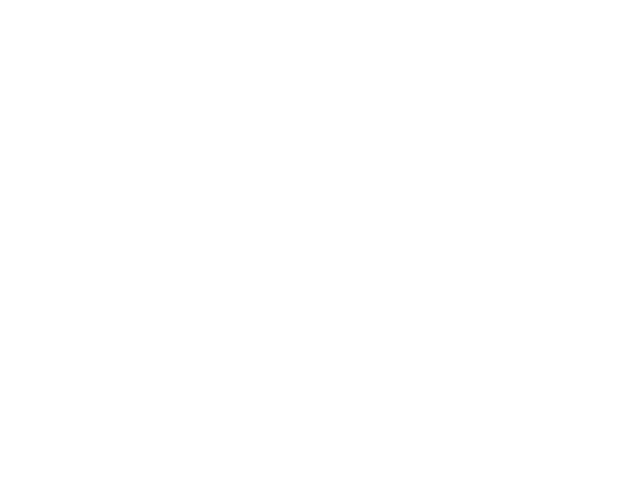

In [1]:
%matplotlib widget
from src.metric import CallCount
from src.common.oracul import LambdaOracul

from src.lab1.stop_condition import CountCondition
import numpy as np
from src.common import Oracul, Point
from src.lab1.method_processor import MethodProcessor
from src.lab1.methods import RandomMethod

import matplotlib.pyplot as plt

fig = plt.figure()

method = RandomMethod()
oracul = LambdaOracul(lambda x, y: x ** 2 + y ** 2, 3)
point, metrics, anim = MethodProcessor.process(method, oracul, CountCondition(20), metrics=[CallCount()], visualize=True,
                                              low_bracket=[-100, -100], high_bracket=[100, 100])
print(metrics)
plt.show()